#**Data Privacy: Computer Homework 01**


Sharif Univesity of  Technology - EE dept.

by Prof. Yassaee, Fall 2023

Contact *@danialayati* if you have any questions.

*Release Date:* 7 Azar 1402

*Soft Deadline:* 21 Azar 1402 - 23:55

*Hard Deadline:* 25 Azar 1402 - 23:55



---



# *Question 1*: In this question we want to demonstrate membership inference attacks on means by test statistics



First, tuneable simulation parameters:

In [1]:
import numpy  as np
import pandas as pd
import seaborn as sns


In [168]:
significance_level = 0.05
dimension = 2000
critical_value = np.sqrt(8 * dimension * np.log(1 / significance_level))
critical_value


218.93313220447894

In [3]:
def make_boolean_projection(d_in, d_out=1):
			"""Returns a (pseudo)random vector predicate function by hashing data."""
			prime = 691
			desc = np.random.randint(prime, size=(d_in, d_out))
			"""this predicate maps data into a ndarray of booleans of size [n, d_out]	       (where `@` is the dot product and `%` modulus)"""
			return lambda data: ((data.values @ desc) % prime % 2).astype(bool)

In [169]:
import pandas as pd
population: pd.DataFrame = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5sample100.csv")

projection = make_boolean_projection(len(population.columns), d_out=dimension)

Then, define utility functions for simulating data and calculating the test statistics:


In [170]:
import numpy as np
import pandas as pd

def random_dataset(data, sample_size):

    """Returns `sample_size` rows randomly from `data`, and the rest"""
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    
    sampled_data = data.iloc[indices[:sample_size]]
    remaining_data = data.iloc[indices[sample_size:]]

    return sampled_data, remaining_data

In [171]:
def simulating_function(population,hypothesis="null",dimension=100,sample_size=5):

	
	dataset, rest_population = random_dataset(population, sample_size)
 
	
	projected_query = projection(dataset).mean(axis=0)
	
	
	projected_reference_sample = projection(population.sample(1).iloc[0])
	
	def get_statistics(projected_target_sample, projected_query, projected_reference_sample):
		
		projected_target_sample = projected_target_sample * 2 - 1
		projected_query = projected_query * 2 - 1
		projected_reference_sample = projected_reference_sample * 2 - 1

		
		target_similarity = projected_target_sample.dot(projected_query)
		reference_similarity = projected_reference_sample.dot(projected_query)
		statistics = target_similarity - reference_similarity
		return statistics
	
	if hypothesis=="null":
		projected_target_sample = projection(dataset.sample(1).iloc[0])
		statistics = get_statistics(projected_target_sample, projected_query, projected_reference_sample)
		
		
	elif hypothesis=="both":
		statistics = []
		projected_target_sample = projection(dataset.sample(1).iloc[0])

		statistics.append(get_statistics(projected_target_sample, projected_query, projected_reference_sample))
		projected_target_sample = projection(rest_population.sample(1).iloc[0])
		statistics.append(get_statistics(projected_target_sample, projected_query, projected_reference_sample))
  		  
	else:
		projected_target_sample = projection(rest_population.sample(1).iloc[0])
		statistics = get_statistics(projected_target_sample, projected_query, projected_reference_sample)

	return statistics

Create Simple graph function for showing the distribution, partitioned by critical value, then Simulate and graph a null distribution:

In [184]:
import seaborn as sns

def graph_function(df):
    plot = sns.histplot(df,kde=True)
    plot.set_xlabel("test statistics")
    plot. axvline(x=critical_value)

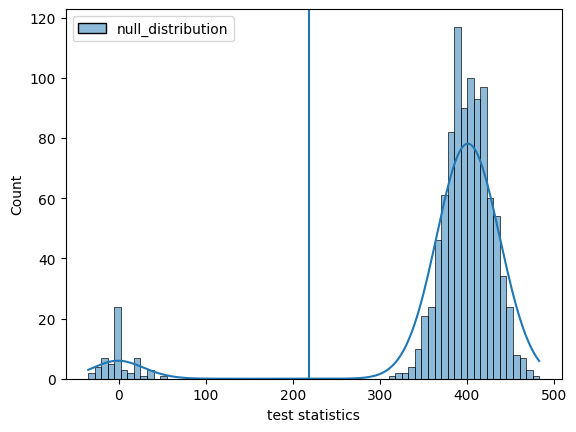

In [185]:
def simulate(population,hypothesis="null",dimension=100,sample_size=5,num_simulations = 1000):
    all_statistics =[]
    for _ in range(num_simulations):
        all_statistics.append(simulating_function(population,hypothesis,dimension,sample_size))
    return all_statistics

null_list = simulate(population,hypothesis="null",dimension=100,sample_size=5,num_simulations = 1000)

dict = {'null_distribution': null_list} 

df = pd.DataFrame(dict)

graph_function(df)

Now create a complete simulation of attack. We are going to iterate across datasets, calculate the discrimination of the test statistic among observations in the private data and the null population.

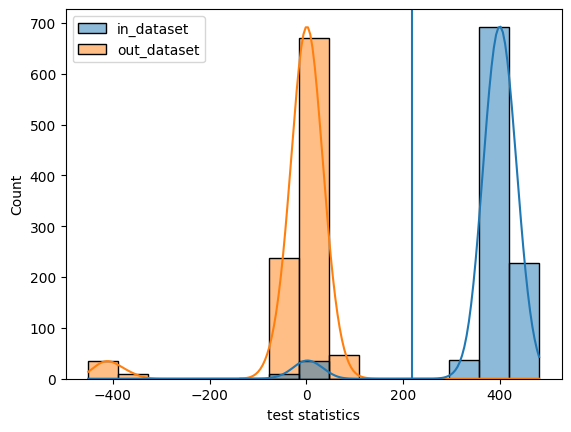

In [186]:
all_list = simulate(population,hypothesis="both",dimension=100,sample_size=5,num_simulations = 1000)

dict = {'in_dataset': [l[0] for l in all_list], 'out_dataset': [l[1] for l in all_list]} 

df = pd.DataFrame(dict)

graph_function(df)



---



# *Question 2:* Now Let's bulid  Laplace Mechanism for Differential Privacy

First, construct the basic building blocks for a Laplace mechanism, a random sampler from the distribution, a clamp/clip/censor function, the function for the true mean, and then the DP release algorithm itself.

In [71]:
def random_sampler(data,sample_size):
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    sampled_data = data.iloc[indices[:sample_size]]
    return sampled_data
def clip(dataset,min_margin,max_margin):
    return dataset.clip(min_margin,max_margin)
def mean_query(dataset):
    return dataset.mean()
def lap_noise(query,scale):
    return np.random.laplace(query, scale)
def lap_mech(dataset,epsilon,sensitivity,min_margin=0,max_margin=20):
    scale = sensitivity/epsilon
    cliped_dataset = clip(dataset,min_margin,max_margin)
    query = mean_query(cliped_dataset)
    private_query = lap_noise(query,scale)
    return private_query, query

Read in the data.  We're going to use the PUMS dataset, and focus on the education variable, a 16 point scale:

In [3]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")


Now that we have a mechanism available, let's try a new one, the histogram.  Histograms give counts of the number of observations within defined partitions of the variable domain.  Consider carefully the sensitivity for the histogram, which depends on which definition of neighbouring we are using. After that,  call your privacy-preserving histogram.

In [4]:
np.random.seed(seed=42)
sampled_data_frame = random_sampler(data,500)
sampled_data_set = sampled_data_frame["educ"]

Educational level counts:
 [  0   6   2   7  11  13  13  17  25 102  27  75  17 119  48  11   7   0
   0]
DP Laplace Educational level counts:
 [ -1.  15.   4.   8.   6.   8.   4.  22.  26. 104.  14.  86.  21. 116.
  44.   7.   5.   0.  -1.]


<Axes: xlabel='bins'>

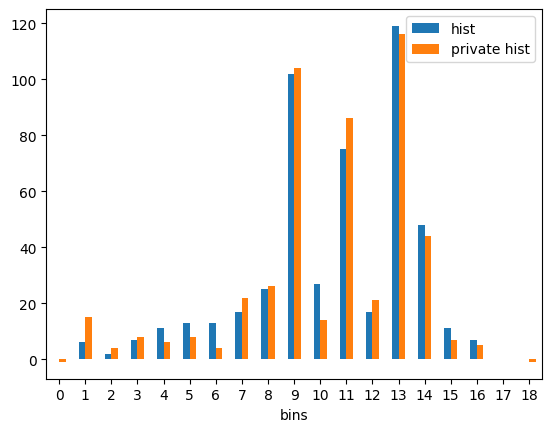

In [11]:
# I used hamming distance for neighboring definition, so the sensitivity of the histogram will be 2
np.random.seed(seed=42)
epsilon = 0.5
sensitivity = 2
scale = sensitivity/epsilon
max_margin =20
min_margin = 0
hist, bins = np.histogram(sampled_data_set, bins =np.arange(min_margin,max_margin)) 
private_hist = lap_noise(hist,scale).round()

print("Educational level counts:\n", hist)
print("DP Laplace Educational level counts:\n", private_hist)

df = pd.DataFrame({'bins': bins[:-1], 'hist': hist, 'private hist': private_hist})
df.plot(x="bins", y=["hist", "private hist"], kind="bar", rot=0)

Now we want to to simulate repeated draws from the Laplace mechanism to examine the utility it offers over the range of epsilon values and dataset sizes, for our education variable. We'll need a way to construct new datasets, given we only have one available.  The (nonparametric) bootstrap function lets us construct datasets even larger than our original source data if needed, by treating the sample data as if it is a population from which we can resample.

Text(0.5, 0, 'Emprical PMF of the dataset')

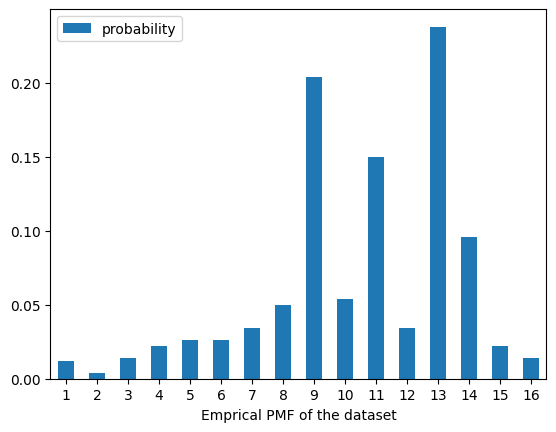

In [15]:
val, cnt = np.unique(sampled_data_set, return_counts=True)
pmf = cnt / len(sampled_data_set)
df = pd.DataFrame({'values': val, 'probability': pmf})
plot = df.plot(x="values", y=["probability"], kind="bar", rot=0)
plot.set_xlabel("Emprical PMF of the dataset")

In [75]:
np.random.seed(seed=42)
def boot_strap_laplace(val,pmf,epsilon,dataset_size,simulation_number,min_margin=0,max_margin=20) :
    sensitivity = (max_margin - min_margin)/dataset_size
    private_means = []
    true_means = []
    for _ in range(simulation_number):
        rand_data = np.random.choice(val, dataset_size, p=pmf)
        private_mean, true_mean = lap_mech(rand_data,epsilon,sensitivity,min_margin,max_margin)
        private_means.append(private_mean)
        true_means.append(true_mean)
    return sum(private_means)/simulation_number,sum(true_means)/simulation_number

Now graph your resluts!

Text(0, 0.5, 'Absolute Error')

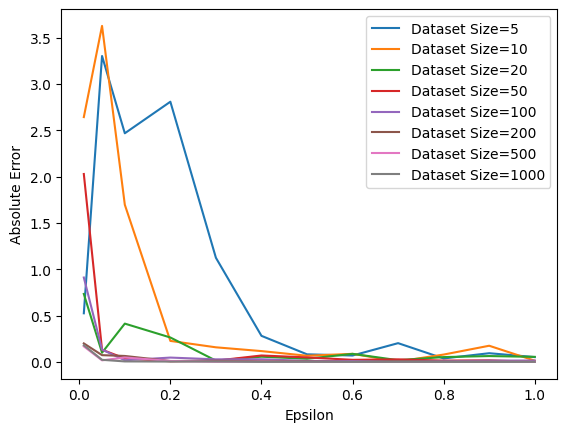

In [109]:
np.random.seed(seed=42)
epsilons = [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.]
dataset_sizes = [5,10,20,50,100,200,500,1000]
df = pd.DataFrame(index=epsilons)
for dataset_size in dataset_sizes:
    all_private_mean = []
    for epsilon in epsilons:
        all_private_mean.append(boot_strap_laplace(val,pmf,epsilon,dataset_size,simulation_number=1000))
    error = [abs(mean[0] - mean[1]) for mean in all_private_mean]
    df[f'Dataset Size={dataset_size}'] = error
    
plot = df.plot()
plot.set_xlabel("Epsilon")
plot.set_ylabel("Absolute Error")



---



# *Question 3:* OPENDP

The OpenDP Project is a community effort to build trustworthy, open source software tools for analysis of private data. The core software of the OpenDP Project is the OpenDP Library.

The OpenDP Library is a modular collection of statistical algorithms that adhere to differential privacy. The library is based on a conceptual framework described in [A Programming Framework for OpenDP](https://projects.iq.harvard.edu/files/opendp/files/opendp_programming_framework_11may2020_1_01.pdf).

The OpenDP Library can be found on GitHub: https://github.com/opendp/opendp/

OpenDP represents computations with Transformations and Measurements. First, recall all you need from opendp, then create a measurement that simply addds laplace noise and like a function.

In [42]:
import opendp
from  opendp import prelude as dp
from opendp.mod import enable_features
enable_features('contrib')

In [43]:
data = pd.read_csv("https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")

In [44]:
data_list = data["educ"].tolist()

In [45]:
min_margin = 0.
max_margin = 20.
edu_bounds =( min_margin,max_margin)
count_release = 500

input_space = dp.vector_domain(dp.atom_domain(T=int)), dp.symmetric_distance()
preprocess = (input_space >>
    dp.t.then_cast_default(TOA=float) >>
    dp.t.then_clamp(bounds=edu_bounds) >>
    dp.t.then_resize(size=count_release, constant=10.)) 

true_mean = dp.t.then_mean() 
sized_bounded_mean = preprocess >> true_mean

base_laplace = dp.m.make_laplace(sized_bounded_mean.output_domain, sized_bounded_mean.output_metric, scale=0.5)

We can also chain transformations and measurements. You might already think of chaining as function composition. The reason why we call it "chaining," instead of "composition," is because composition has a special meaning in differential privacy. In the context of differential privacy, composition refers to the joint release of more than one measurement.

In [46]:
# chain with the base_laplace measurement
dp_mean= sized_bounded_mean >> base_laplace

# release a dp mean
dp_mean(data_list)

10.547073597664598

Now that we've shown how to build up computations and execute them, lets talk about distances.

Transformations and Measurements relate distances. There are three kinds of distances:

1. Dataset distances  
    (greatest distance between neighboring datasets)
1. Sensitivities  
    (greatest distance between queries on neighboring datasets)
1. Privacy budget    
    (greatest distance between the probability distributions)

The following shows how the `base_laplace` measurement relates a `sensitivity` to a privacy budget, `epsilon`.

In [47]:
# Check that when sensitivity is 0.15, the privacy usage is .30
base_laplace.check(d_in=.15, d_out=.30)

True

We can interpret this as: If the sensitivity is .15, then we could release the query answer with `laplace(scale=.5)` noise at a privacy expenditure of `.3 epsilon`. Equivalently, this data release is `.3 differentially private`, or `.3-DP`, where the privacy units are implicitly in terms of epsilon.

If we were to increase the sensitivity, the same relation would fail, and the release would not be `.3-DP`.

In [48]:
base_laplace.check(d_in=.2, d_out=.30)

False

As you might expect, the relation will also pass for any sensitivity that is smaller, or any privacy expenditure that is larger. And similarly, the `sized_bounded_mean` transformation relates a dataset distance `max_influence` to a `sensitivity`.

In [49]:
max_influence = 1
eps = 0.3
sensitivity = 0.15
sized_bounded_mean.check(d_in=max_influence, d_out=sensitivity)

True

Now relate distances on chained computations. The units for the input and output distances come from the constituent transformations and measurements.

For example, when we chain the `sized_bounded_mean` transformation and `base_laplace` measurement together, the input distance is a dataset distance, `max_influence`, and the output distance is measured in terms of a privacy budget, `epsilon`.

In [50]:
dp_mean.check(d_in=max_influence, d_out=eps)

True

The `release_histogram` function behaves similarly to the `make_count_by_categories` function in OpenDP.

In [51]:
help(dp.t.make_count_by_categories)

Help on function make_count_by_categories in module opendp.transformations:

make_count_by_categories(input_domain, input_metric, categories: Any, null_category: bool = True, MO: opendp.typing.SensitivityMetric = 'L1Distance<int>', TOA: Union[ForwardRef('RuntimeType'), str, Type[Union[List, Tuple, int, float, str, bool]], tuple, _GenericAlias, types.GenericAlias] = 'int') -> opendp.mod.Transformation
    Make a Transformation that computes the number of times each category appears in the data.
    This assumes that the category set is known.
    
    [make_count_by_categories in Rust documentation.](https://docs.rs/opendp/0.8.0/opendp/transformations/fn.make_count_by_categories.html)
    
    **Citations:**
    
    * [GRS12 Universally Utility-Maximizing Privacy Mechanisms](https://theory.stanford.edu/~tim/papers/priv.pdf)
    * [BV17 Differential Privacy on Finite Computers](https://arxiv.org/abs/1709.05396)
    
    **Supporting Elements:**
    
    * Input Domain:   `VectorDomain<A

Educational level counts:
 [0, 5, 5, 5, 10, 13, 10, 17, 20, 103, 27, 70, 19, 131, 43, 16, 6, 0, 0, 0]
DP Laplace Educational level counts:
 [0, 6, 2, 8, 6, 10, 7, 23, 18, 108, 25, 83, 30, 120, 35, 17, 3, 0, 1, 0]


<Axes: xlabel='bins'>

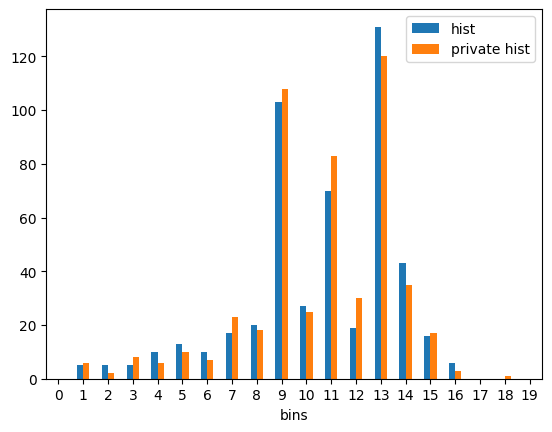

In [52]:
# release a histogram with laplace noise
min_margin = 0
max_margin = 20
categories = [str(category) for category in np.arange(min_margin, max_margin)]
input_space = dp.vector_domain(dp.atom_domain(T=int)), dp.symmetric_distance()
histogram = (input_space >> dp.t.then_cast_default(TOA=float) >>
    dp.t.then_resize(size=count_release, constant=10.)>> 
    dp.t.then_cast_default(TOA=str) >>
    dp.t.then_count_by_categories(categories=categories))
noisy_histogram = histogram >> dp.m.then_laplace(scale=0.5)
hist = histogram(data_list)
private_hist = noisy_histogram(data_list)

print("Educational level counts:\n", hist[:-1])
print("DP Laplace Educational level counts:\n", private_hist[:-1])

df = pd.DataFrame({'bins': np.arange(min_margin, max_margin), 'hist': hist[:-1], 'private hist': private_hist[:-1]})

df.plot(x="bins", y=["hist", "private hist"], kind="bar", rot=0)


Educational level counts:
 [0, 7, 2, 7, 15, 7, 14, 25, 20, 102, 25, 84, 18, 114, 40, 13, 7, 0, 0, 0]
DP Geometric Educational level counts:
 [1, 6, 2, 5, 10, 9, 20, 14, 16, 98, 34, 78, 18, 114, 44, 21, 11, 0, 0, 0]


<Axes: xlabel='bins'>

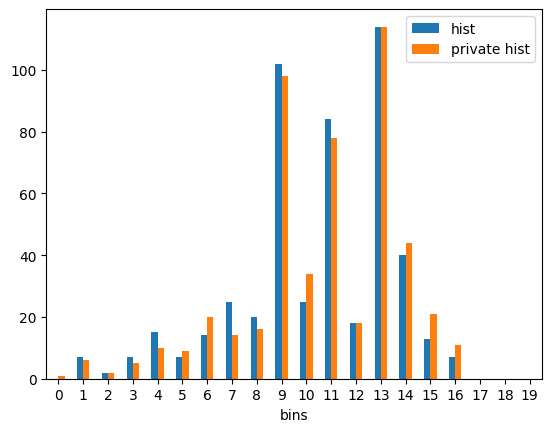

In [53]:
# release a histogram with geometric noise
noisy_histogram = histogram >> dp.m.make_base_geometric(histogram.output_domain, histogram.output_metric,scale=0.5)
hist = histogram(data_list)
private_hist = noisy_histogram(data_list)
print("Educational level counts:\n", hist[:-1])
print("DP Geometric Educational level counts:\n", private_hist[:-1])

df = pd.DataFrame({'bins': np.arange(min_margin, max_margin), 'hist': hist[:-1], 'private hist': private_hist[:-1]})

df.plot(x="bins", y=["hist", "private hist"], kind="bar", rot=0)



---



# *Question 4:* Gaussian Mechanism

Let's extend the basic building blocks to include a Gaussian mechanism and a random sampler from the Gaussian.

In [102]:
def random_sampler(data,sample_size):
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    sampled_data = data.iloc[indices[:sample_size]]
    return sampled_data
def clip(dataset,min_margin,max_margin):
    return dataset.clip(min_margin,max_margin)
def mean_query(dataset):
    return dataset.mean()
def gaussian_noise(query,variance):
    return np.random.normal(query, np.sqrt(variance))
def gaussian_mech(dataset,epsilon,sensitivity,min_margin=0,max_margin=20,delta=1e-8):
    variance = (2*np.power(sensitivity,2)*np.log(2/delta))/np.power(epsilon,2)
    cliped_dataset = clip(dataset,min_margin,max_margin)
    query = mean_query(cliped_dataset)
    private_query = gaussian_noise(query,variance)
    return private_query, query

Read in the data. We are using the familiar PUMS dataset we are familiar with, and focusing on the education variable, a 16 point scale.

In [64]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")

Now simulate repeated draws from both mechanisms to compare the utility they offer over a range of epsilon values and dataset sizes.  

Text(0.5, 0, 'Emprical PMF of the dataset')

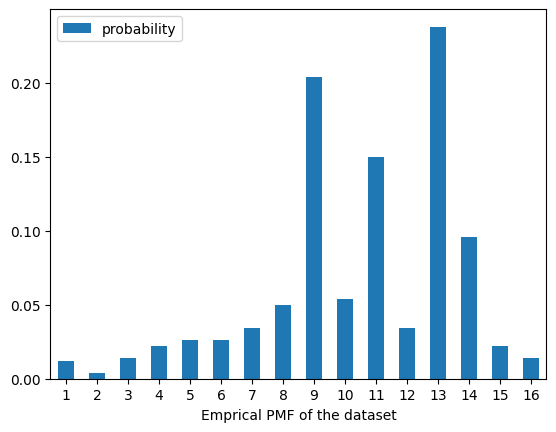

In [65]:
np.random.seed(seed=42)
sampled_data_frame = random_sampler(data,500)
sampled_data_set = sampled_data_frame["educ"]
val, cnt = np.unique(sampled_data_set, return_counts=True)
pmf = cnt / len(sampled_data_set)
df = pd.DataFrame({'values': val, 'probability': pmf})
plot = df.plot(x="values", y=["probability"], kind="bar", rot=0)
plot.set_xlabel("Emprical PMF of the dataset")

In [95]:
np.random.seed(seed=42)
def boot_strap_gaussian_laplace(val,pmf,epsilon,dataset_size,simulation_number,min_margin=0,max_margin=20) :
    sensitivity = (max_margin - min_margin)/dataset_size
    private_means_gaussian = []
    private_means_laplace = []
    true_means = []
    for _ in range(simulation_number):
        rand_data = np.random.choice(val, dataset_size, p=pmf)
        private_mean_gaussian, true_mean = gaussian_mech(rand_data,epsilon,sensitivity,min_margin,max_margin)
        private_mean_laplace, _ = lap_mech(rand_data,epsilon,sensitivity,min_margin,max_margin)
        private_means_gaussian.append(private_mean_gaussian)
        private_means_laplace.append(private_mean_laplace)
        true_means.append(true_mean)
    return sum(private_means_gaussian)/simulation_number,sum(private_means_laplace)/simulation_number,sum(true_means)/simulation_number

And Finally Graph your result:

Text(0, 0.5, 'Absolute Error')

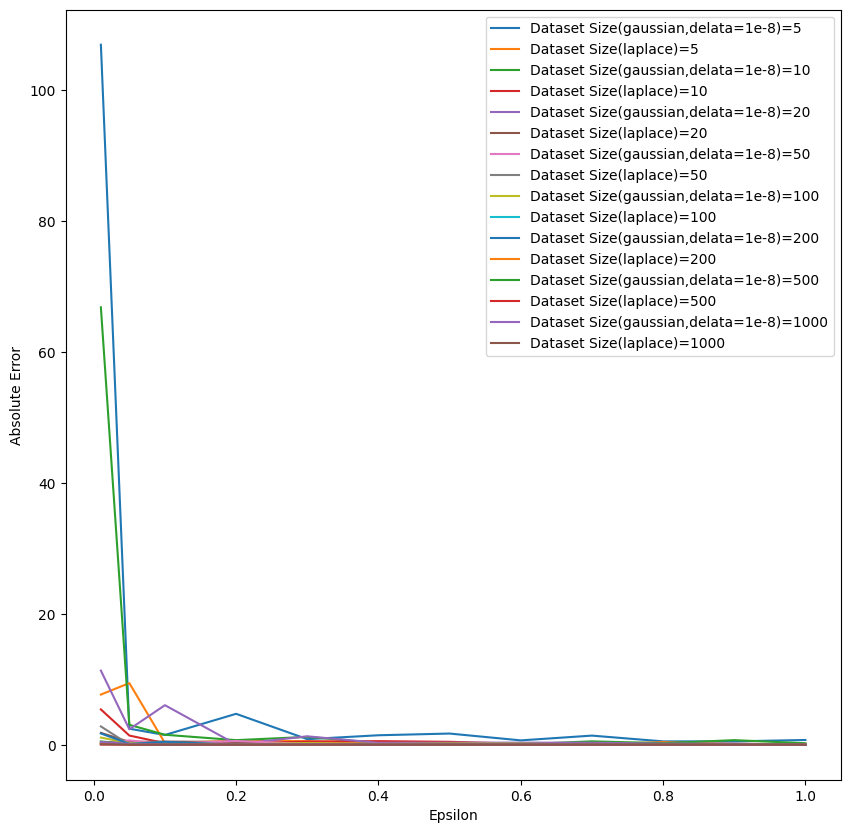

In [108]:
np.random.seed(seed=42)
epsilons = [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.]
dataset_sizes = [5,10,20,50,100,200,500,1000]
df = pd.DataFrame(index=epsilons)
for dataset_size in dataset_sizes:
    all_private_mean = []
    for epsilon in epsilons:
        all_private_mean.append(boot_strap_gaussian_laplace(val,pmf,epsilon,dataset_size,simulation_number=1000))
        
    error_gaussian = [abs(mean[0] - mean[2]) for mean in all_private_mean]
    error_laplace = [abs(mean[1] - mean[2]) for mean in all_private_mean]
    df[f'Dataset Size(gaussian,delata=1e-8)={dataset_size}'] = error_gaussian
    df[f'Dataset Size(laplace)={dataset_size}'] = error_laplace
    
plot = df.plot(figsize=(10, 10))
plot.set_xlabel("Epsilon")
plot.set_ylabel("Absolute Error")
